In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

sns.set(style='whitegrid', context='notebook')

#Check device for NN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_csv('ECGCvdata 2.csv') #replace obv
df.shape

(1200, 56)

In [3]:
df.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,292.296636,18.457618,63.615239,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,ARR
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,318.563915,23.043230,67.787773,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,ARR
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,273.165412,10.756353,29.253827,-0.042542,NaN,NaN,0.027131,16,42.105263,ARR
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,313.046941,23.845086,65.228737,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,ARR
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,263.225676,20.942791,72.830353,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,ARR


In [4]:
df.isnull().sum()

RECORD          0
hbpermin        0
Pseg            0
PQseg           0
QRSseg          0
QRseg           0
QTseg           0
RSseg           0
STseg           0
Tseg            0
PTseg           0
ECGseg          0
QRtoQSdur     769
RStoQSdur     769
RRmean          0
PPmean          0
PQdis           0
PonQdis         0
PRdis           0
PonRdis         0
PSdis           0
PonSdis         0
PTdis           0
PonTdis         0
PToffdis        0
QRdis           0
QSdis           0
QTdis           0
QToffdis        0
RSdis           0
RTdis           0
RToffdis        0
STdis           0
SToffdis        0
PonToffdis      0
PonPQang      557
PQRang        768
QRSang        769
RSTang        769
STToffang     426
RRTot           0
NNTot           0
SDRR            0
IBIM            0
IBISD           0
SDSD            0
RMSSD           0
QRSarea         0
QRSperi         0
PQslope         0
QRslope       768
RSslope       769
STslope         0
NN50            0
pNN50           0
ECG_signal

In [5]:
# Noticing a lot of NULLS with some entries not having complete data, we will see how valid those stats are 
# And decide if we are able to drop them 

In [6]:
# 1) Drop columns with >50% missing
missing_pct = (df.isnull().sum() / len(df)) * 100
high_missing_cols = missing_pct[missing_pct > 50].index.tolist()
df_clean = df.drop(columns=high_missing_cols)

In [7]:
# Fill NaNs left with median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [8]:
#Show different results for ECG_signal
print(sorted(df['ECG_signal'].unique().tolist()))
# AFF = Atrial Fibrillation: Rapid irregular atrial activity
# ARR = Arrhythmia: Abnormal Rhytms aren't speficially labeled
# CHF = Congestive Heart Failure: Not rhytm but heart fail;ure
# NSR = Normal Sinus Rhythm: healthy regular heartbeat

['AFF', 'ARR', 'CHF', 'NSR']


In [9]:
# 
df_encoded = pd.get_dummies(df, columns=['ECG_signal'], dtype=int)
df_encoded.sum()

RECORD            720600.000000
hbpermin           98272.776075
Pseg                  73.082444
PQseg                 93.719023
QRSseg                57.885235
QRseg                 29.324903
QTseg                169.849209
RSseg                 28.560332
STseg                111.963973
Tseg                 123.256759
PTseg                263.568231
ECGseg               356.592907
QRtoQSdur              1.059356
RStoQSdur              1.045123
RRmean            231114.202342
PPmean            231094.044061
PQdis              23049.527807
PonQdis            32085.741286
PRdis              30276.172202
PonRdis            39316.865222
PSdis              37340.498572
PonSdis            46378.870410
PTdis              65156.208838
PonTdis            74225.433921
PToffdis           79331.910139
QRdis               7280.302738
QSdis              14294.925229
QTdis              42170.051629
QToffdis           56340.819602
RSdis               7123.787308
RTdis              34943.751666
RToffdis

In [10]:
df_encoded.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal_AFF,ECG_signal_ARR,ECG_signal_CHF,ECG_signal_NSR
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,0,1,0,0
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,0,1,0,0
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,-0.042542,NaN,NaN,0.027131,16,42.105263,0,1,0,0
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,0,1,0,0
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,0,1,0,0


In [11]:
feature_list = ['RRmean', 'PPmean', 'RTdis', 'PonTdis', 'PonToffdis', 'QTdis',
                'IBIM', 'NN50', 'hbpermin', 'RSslope', 'RRTot', 'NNTot', 'STslope']

feature_list = [c for c in feature_list if c in df_encoded.columns]

In [12]:
# Linear regression R^2 for EACH class (using your feature_list)
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

X = df_encoded[feature_list]
label_cols = [c for c in df_encoded.columns if c.startswith('ECG_signal_')]

pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    LinearRegression()
)

r2_table = []

for lab in label_cols:
    y = df_encoded[lab].astype(float)
    mask = y.notna()               # (y should be clean, but keep it consistent)
    X_use = X.loc[mask]
    y_use = y.loc[mask]
    if y_use.nunique() <= 1:       # constant target => R² undefined
        r2 = np.nan
    else:
        pipe.fit(X_use, y_use)
        r2 = pipe.score(X_use, y_use)
    r2_table.append((lab, r2))

# Show R^2 sorted (highest first)
r2_table = sorted(r2_table, key=lambda x: x[1], reverse=True)
r2_table

[('ECG_signal_NSR', 0.9471558372582268),
 ('ECG_signal_ARR', 0.8003051696057338),
 ('ECG_signal_CHF', 0.4918298317154365),
 ('ECG_signal_AFF', 0.4544285744150257)]

In [13]:
# As we can tell the regular one is MUCH higher than the rest.
# Adding a proper classifier + CV AUC

In [14]:
# See which features were dropped and which remain
set(['RRmean','PPmean','RTdis','PonTdis','PonToffdis','QTdis','IBIM','NN50','hbpermin','RSslope','RRTot','NNTot','STslope']) - set(df_encoded.columns)

# Confirm X is clean *after* imputation is applied in the pipeline (no need to impute here)
df_encoded[feature_list].isna().sum().sort_values(ascending=False).head(10)

# Check label balance
df_encoded[label_cols].sum()


ECG_signal_AFF    300
ECG_signal_ARR    300
ECG_signal_CHF    300
ECG_signal_NSR    300
dtype: int64

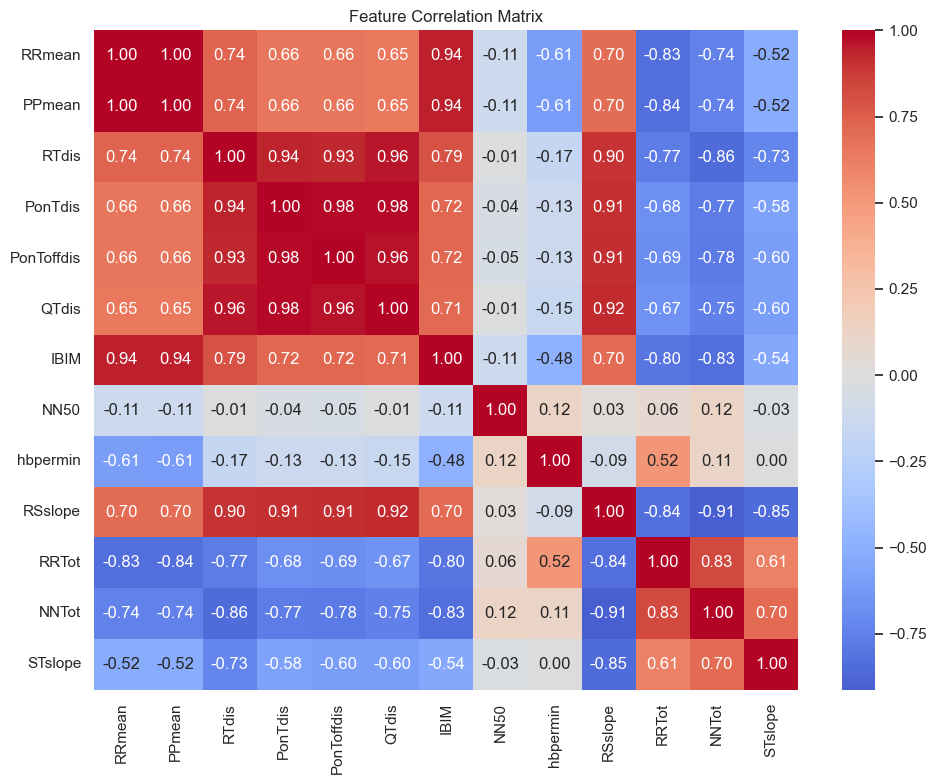

Highly correlated features (>0.9):
RRmean <-> PPmean: 1.000
RRmean <-> IBIM: 0.944
PPmean <-> IBIM: 0.944
RTdis <-> PonTdis: 0.938
RTdis <-> PonToffdis: 0.933
RTdis <-> QTdis: 0.958
RTdis <-> RSslope: 0.901
PonTdis <-> PonToffdis: 0.981
PonTdis <-> QTdis: 0.979
PonTdis <-> RSslope: 0.906
PonToffdis <-> QTdis: 0.964
PonToffdis <-> RSslope: 0.911
QTdis <-> RSslope: 0.918
RSslope <-> NNTot: -0.912


In [15]:
# Check correlations among features
corr_matrix = df_encoded[feature_list].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (>0.9)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print("Highly correlated features (>0.9):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")

In [ ]:
# Dropping PPmean as same as RR
features_final = [f for f in feature_list if f not in ['PPmean']]

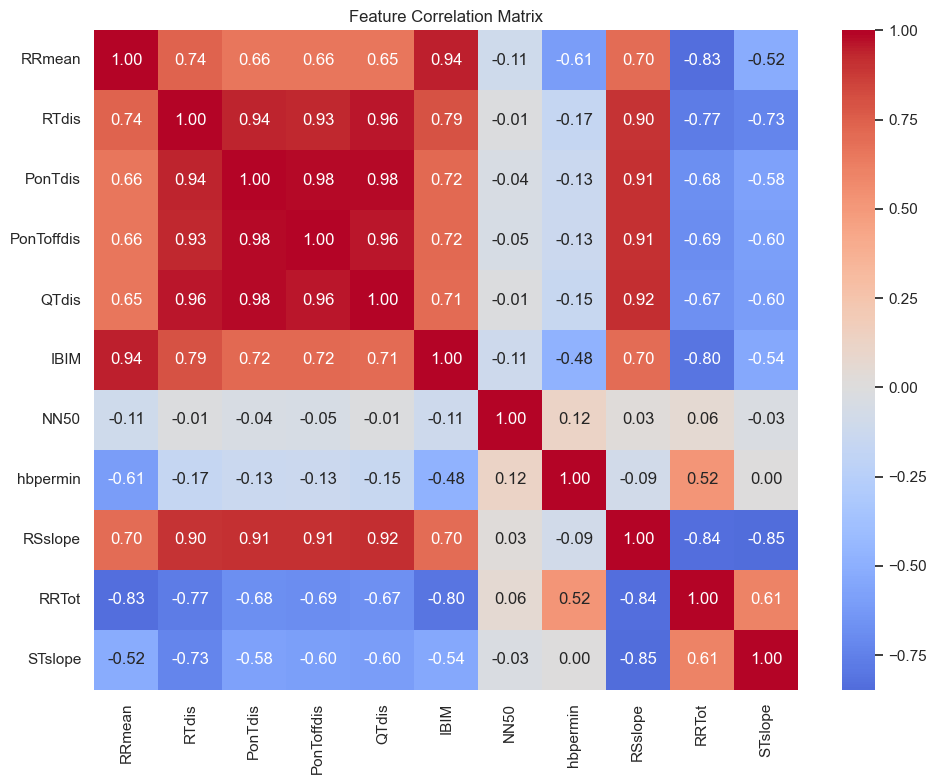

Highly correlated features (>0.9):
RRmean <-> IBIM: 0.944
RTdis <-> PonTdis: 0.938
RTdis <-> PonToffdis: 0.933
RTdis <-> QTdis: 0.958
RTdis <-> RSslope: 0.901
PonTdis <-> PonToffdis: 0.981
PonTdis <-> QTdis: 0.979
PonTdis <-> RSslope: 0.906
PonToffdis <-> QTdis: 0.964
PonToffdis <-> RSslope: 0.911
QTdis <-> RSslope: 0.918


In [17]:
# Check correlations among features
corr_matrix = df_encoded[features_final].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (>0.9)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print("Highly correlated features (>0.9):")
for feat1, feat2, corr in high_corr:
    print(f"{feat1} <-> {feat2}: {corr:.3f}")

In [18]:
# Train/Val/Test Split

X = df_encoded[features_final]
y = df_encoded[label_cols].values

y_labels = df_encoded[label_cols].idxmax(axis=1).str.replace('ECG_Signal_','')

# Spliting: 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_labels, test_size=0.4, stratify=y_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"Train distribution:\n{y_train.value_counts()}")

Train: 720, Val: 240, Test: 240
Train distribution:
ECG_signal_AFF    180
ECG_signal_CHF    180
ECG_signal_NSR    180
ECG_signal_ARR    180
Name: count, dtype: int64


In [19]:
# One note is that RRmean and PPmean being 1 is not a red flag, but should not be used 
# To train the model 